In [53]:
BB = [2]
SS =150

In [2]:
# -*- coding: UTF-8 -*-

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime
%matplotlib inline


# 1. Read data

In [4]:
def readData(filePath, index_col='Date'):
    data = pd.read_csv(filePath, 
                     sep=',', 
                     header=1, 
                     parse_dates = True, 
                     index_col=index_col)
    data = data.iloc[:-4,:-1] # cut NAN
    #data = data.iloc[:, 2:6] # cut string
    #print('data', type(data), data.shape, len(data))
    #data
    return data

# 2. Data preprocessing

In [5]:
def generateBars(data, criteria, threshold):
    _time = data['date'].values
    _open = data['open'].values
    _high = data['high'].values
    _low = data['low'].values
    _close = data['close'].values    
    _ticks = data['tradecount'].values
    _volume = data['Volume BTC'].values
    _dollar = data['Volume USDT'].values
    times = []
    opens = []
    highs = []
    lows = []
    closes = []
    ticks = []
    volumes = []
    dollars = []
    
    cum_ticks = []
    cum_volumes = []
    cum_dollars = []
    
    if (criteria == 'time'):
        info = []
        for i in range(len(_open)):
            info.append(1)
    elif (criteria == 'tick'):
        info = _ticks
    elif (criteria == 'volume'):
        info = _volume
    elif (criteria == 'dollar'):
        info = _dollar
    else:
        print("wrong criteria")
    info_amount = 0
    tick_amount = 0
    volume_amount = 0
    dollar_amount = 0
    j = -1
    for i in range(len(_time)):
        info_amount += info[i]
        tick_amount += _ticks[i]
        volume_amount += _volume[i]
        dollar_amount += _dollar[i]
        j += 1
        if ((i == len(_time) - 1) or (info_amount + info[i + 1] >= threshold)):
            times.append(_time[i - j])
            ticks.append(tick_amount)
            volumes.append(volume_amount)
            dollars.append(dollar_amount)
            opens.append(_open[i])
            highs.append(np.max(_high[i - j:i+1]))
            lows.append(np.min(_low[i - j:i+1]))
            closes.append(_close[i - j])
            
            if len(cum_ticks) == 0:
                cum_ticks.append(int(tick_amount))
                cum_volumes.append(int(volume_amount))
                cum_dollars.append(int(dollar_amount))
            else:
                cum_ticks.append(int(tick_amount+cum_ticks[-1]))
                cum_volumes.append(int(volume_amount+cum_volumes[-1]))
                cum_dollars.append(int(dollar_amount+cum_dollars[-1]))
            
            
            tick_amount = 0
            volume_amount = 0
            dollar_amount = 0
            info_amount = 0
            j = -1
    bars = np.zeros(shape=(len(times), 7))
    for i in range(len(times)):
        bars[i][0] = opens[i]
        bars[i][1] = highs[i]
        bars[i][2] = lows[i]
        bars[i][3] = closes[i]
        bars[i][4] = ticks[i]
        bars[i][5] = volumes[i]
        bars[i][6] = dollars[i]
    times = np.array(times)
    #return bars, times
    
    print(len(times), len(cum_ticks), len(cum_volumes), len(cum_dollars))
    
    if (criteria == 'time'):
        return bars, times
    elif (criteria == 'tick'):
        return bars, cum_ticks
    elif (criteria == 'volume'):
        return bars, cum_volumes
    elif (criteria == 'dollar'):
        return bars, cum_dollars
    else:
        print("wrong criteria")
        return

In [6]:
def dataSet(date, data, inputDays, outputDays, O, H, L, C):
    # X: 3d: n x inputDays x features
    # Y: 2d: n x outputDays
    # date:  n
    X, Y, dates= [], [], []
    y = [0]*outputDays # list not array
    for n in range(data.shape[0]-outputDays-inputDays):
        for o in range(outputDays):
            y[o] = data[n + inputDays + o, C] #- data[n + inputDays - 1, C]
        Y.append(np.array(y))
        dates.append(np.array(date[n + inputDays - 1:n + inputDays - 1 + outputDays]))   
    #for n in range(data.shape[0]):
        #data[n, H] = data[n, H] - data[n, H]
        #data[n, L] = data[n, L] - data[n, L]
        #data[n, C] = data[n, C] - data[n, O]
    for n in range(data.shape[0]-outputDays-inputDays):
        X.append(np.array(data[n:n + inputDays])) 
    return np.array(dates), np.array(X), np.array(Y)

In [7]:
import mpl_finance as mpf
import matplotlib.ticker as ticker
%matplotlib inline

D:\Engineering\my_Python\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


def candlestickChart(Bars, times):
    fig = plt.figure(figsize=(24, 20))
    ax = fig.add_axes([0,0.3,1,0.4])
    ax.set_xticks(range(0, len(times), 1))
    ax.set_xticklabels(times)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(int(len(times)/10)))
    mpf.candlestick2_ochl(ax, Bars[:,1], Bars[:,4], Bars[:,2], Bars[:,3],
                          width=0.6, colorup='r', colordown='g', alpha=0.75)



In [8]:
def sign(x):
    y = []
    for i in range(len(x)):
        if x[i] > 0:
            y.append(1)
        elif x[i] < 0:
            y.append(-1)
        else:
            y.append(0)
    return y

# 3. Split to training set and testing set

In [9]:
def dataSplit(date, X, Y, train_size):
    splitter = round(len(X) * train_size)
    date_train, date_test = date[:splitter], date[splitter:]
    X_train, X_test, Y_train, Y_test = X[:splitter], X[splitter:], Y[:splitter], Y[splitter:]
    #print('date:', date_train.shape, date_test.shape, 'X:', X_train.shape, X_test.shape, 'Y:', Y_train.shape, Y_test.shape)
    return date_train, date_test, X_train, X_test, Y_train, Y_test

# 4. Build model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# 5. Hyperparameter tuning

# 6. Plot result


In [11]:
def plotResult(title, x, y, y1):
    fig =plt.figure(figsize=(12,10))
    ax = fig.add_axes([0,0.3,1,0.4])
    ax.set_xticks(range(0, len(x), 1))
    ax.set_xticklabels(x)
    if len(x) > 20:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(int(len(x)/20)))
    plt.xticks(rotation=45)
    plt.plot(x, y, label='real',linewidth=2, color='r')
    plt.plot(x, y1, label='prediction1',linewidth=2, color='b')
    #plt.plot(x, y2, label='prediction2',linewidth=2)
    plt.legend()
    plt.title(title)
    plt.xlabel('time')
    plt.ylabel('price')
    plt.show

In [12]:
def plotALL(title, x, answer,x1, y1, x2, y2):
    fig =plt.figure(figsize=(12,10))
    ax = fig.add_axes([0,0.3,1,0.4])
    ax.set_xticks(range(0, len(x), 1))
    ax.set_xticklabels(x)
    if len(x) > 20:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(int(len(x)/20)))
    plt.xticks(rotation=45)
    plt.plot(x, answer, label='answer',linewidth=1, color="tab:blue")
    plt.plot(x1, y1, label='training set',linewidth=1, color="tab:green")
    plt.plot(x2, y2, label='testing set',linewidth=1, color="tab:orange")
    plt.legend()
    plt.title(title)
    plt.xlabel('time')
    plt.ylabel('price')
    plt.show

In [13]:
def check(a, b):
    c = []
    right = 0
    for i in range(len(a)):
        #print(a[i], b[i], a[i]==b[i])
        c.append(a[i]==b[i])
        right += (a[i]==b[i])
    accuracy = right / len(a)
    return c, accuracy

In [14]:
def stockWave(Open, Close, prediction):
    realWave = []
    predictWave = []
    realWave.append(Close[0] - Open[0])
    predictWave.append(0)
    for i in range(1,len(prediction)):
        realWave.append(Close[i] - Open[i])
        predictWave.append(prediction[i] - Open[i])
        #predictWave.append(prediction[i] - prediction[i - 1])
    return realWave, predictWave

In [15]:
def plotWave(title, x, y, y1):
    zeros = [0]*len(x)
    fig =plt.figure(figsize=(12,5))
    ax = fig.add_axes([0,0.3,1,0.4])
    ax.set_xticks(range(0, len(x), 1))
    ax.set_xticklabels(x)
    if len(x) > 20:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(int(len(x)/20)))
    plt.xticks(rotation=45)
    plt.plot(x, y, label='answer',linewidth=2, color='tab:blue')
    plt.plot(x, y1, label='testing set',linewidth=2, color='tab:orange')
    plt.plot(x, zeros, label='zeros',linewidth=2, color='tab:green')
    plt.legend()
    plt.title(title)
    plt.xlabel('time')
    plt.ylabel('price')
    plt.show

# 7.implementation

In [54]:
#files = stock2317
inputDays = 20
outputDays = 1
SIZE = 0.7 # train size
test_partition = 10

In [55]:
data = pd.read_csv('../../data/Binance_BTCUSDT_minute.csv', 
                 sep=',', 
                 header=1, 
                 parse_dates = True, 
                 index_col=['unix'])
data = data.iloc[::-1]
cut = 2000
start = 100000
size = SS
data = data.iloc[start+cut:start+cut+size]
data

,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
unix,,,,,,,,,
1574085480000,2019-11-18 13:58:00,BTC/USDT,8446.20,8454.48,8446.20,8451.92,94.783,801059.46679,211
1574085540000,2019-11-18 13:59:00,BTC/USDT,8451.85,8451.85,8446.01,8446.12,44.508,376062.70050,127
1574085600000,2019-11-18 14:00:00,BTC/USDT,8447.10,8452.85,8446.14,8451.77,37.083,313330.51748,146
1574085660000,2019-11-18 14:01:00,BTC/USDT,8452.60,8456.60,8452.00,8455.06,28.755,243132.68709,114
1574085720000,2019-11-18 14:02:00,BTC/USDT,8455.06,8456.85,8451.41,8451.41,85.837,725744.98003,131
...,...,...,...,...,...,...,...,...,...
1574094180000,2019-11-18 16:23:00,BTC/USDT,8423.59,8423.60,8422.00,8423.05,3.917,32992.51211,42
1574094240000,2019-11-18 16:24:00,BTC/USDT,8423.04,8424.34,8422.05,8423.00,9.658,81351.88932,56
1574094300000,2019-11-18 16:25:00,BTC/USDT,8423.00,8427.15,8423.00,8424.79,20.948,176488.31091,91


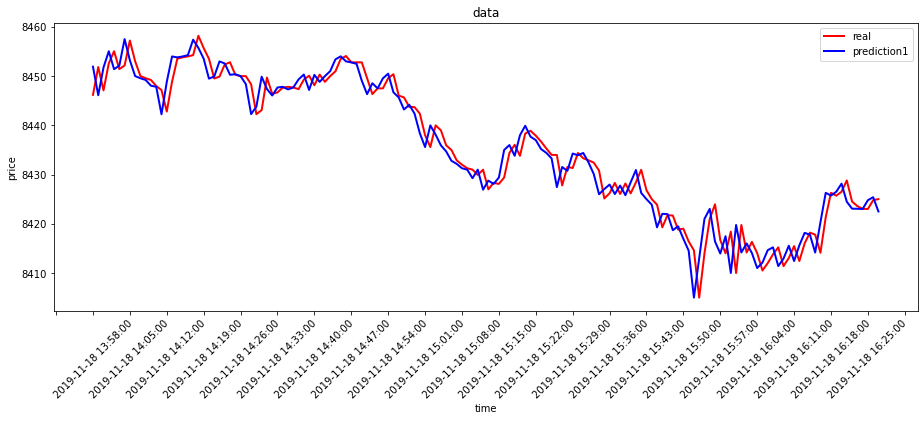

In [56]:
plotResult('data', data["date"], data["open"], data["close"])

In [57]:
data = data.drop(columns=['symbol'])

In [58]:
data

,date,open,high,low,close,Volume BTC,Volume USDT,tradecount
unix,,,,,,,,
1574085480000,2019-11-18 13:58:00,8446.20,8454.48,8446.20,8451.92,94.783,801059.46679,211
1574085540000,2019-11-18 13:59:00,8451.85,8451.85,8446.01,8446.12,44.508,376062.70050,127
1574085600000,2019-11-18 14:00:00,8447.10,8452.85,8446.14,8451.77,37.083,313330.51748,146
1574085660000,2019-11-18 14:01:00,8452.60,8456.60,8452.00,8455.06,28.755,243132.68709,114
1574085720000,2019-11-18 14:02:00,8455.06,8456.85,8451.41,8451.41,85.837,725744.98003,131
...,...,...,...,...,...,...,...,...
1574094180000,2019-11-18 16:23:00,8423.59,8423.60,8422.00,8423.05,3.917,32992.51211,42
1574094240000,2019-11-18 16:24:00,8423.04,8424.34,8422.05,8423.00,9.658,81351.88932,56
1574094300000,2019-11-18 16:25:00,8423.00,8427.15,8423.00,8424.79,20.948,176488.31091,91


In [59]:
from tensorflow import convert_to_tensor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [60]:
# index of columns
O_ = 0
H_ = 1
L_ = 2
C_ = 3
T_ = 4
V_ = 5
D_ = 6

In [61]:
def ManyToManyModel(shape, outputDays):
    cells = 100
    model = Sequential()
    model.add(LSTM(cells, input_length=shape[1], input_dim=shape[2],return_sequences=True))
    model.add(LSTM(cells ,return_sequences=True))
    model.add(LSTM(cells))
    # output shape: (1, 1)
    model.add(Dense(outputDays))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [62]:
def run(data, BarType, quantity, inputDays):
    acc = []
    ms, Ms = [], []
    
    Bars, times = generateBars(data, BarType, quantity)
    data2 = np.array(Bars)
    times2 = times
    #normalize
    for tag in range(data2.shape[1]):
        m = np.min(data2[:, tag]) 
        M = np.max(data2[:, tag])
        mean = np.mean(data2[:, tag])
        S = np.std(data2[:, tag])
        ms.append(m)
        Ms.append(M)
        for n in range(data2.shape[0]):
            data2[n, tag] = (data2[n, tag] - m) / (M -m)
    date, X, Y = dataSet(times2, data2, inputDays, outputDays, O_, H_, L_, C_)
    date_train, date_test, X_train, X_test, Y_train, Y_test = dataSplit(date, X, Y, SIZE)
    # convert data to tensor

    X_train = convert_to_tensor(X_train, np.float32)
    Y_train = convert_to_tensor(Y_train, np.float32)
    X_test = convert_to_tensor(X_test, np.float32)
    Y_test = convert_to_tensor(Y_test, np.float32)

    #model = ManyToOneModel(X_train.shape)
    model = ManyToManyModel(X_train.shape, outputDays)
    callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
    model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_data=(X_test[:600], Y_test[:600]), callbacks=[callback])
    predict_train = model.predict(X_train)

    

    for i in range(outputDays):
        #realWave = Y_test[:, i]
        #predictWave = predict_test[:, i]
        realWave, predictWave = stockWave(X_train[:,inputDays-1, C_], Y_train[:,i], predict_train[:,i])
        c1, accuracy1 = check(sign(realWave), sign(predictWave))
        w1 = sign(realWave)
        plotWave('change of stock price', date_train[:,i], realWave, predictWave)

        
        part_size = int(len(X_test)/test_partition)
        for p in range(test_partition):
            #print(X_test.shape, Y_test.shape)
            x_test = X_test[p*part_size:(p+1)*part_size,:,:]
            y_test = Y_test[p*part_size:(p+1)*part_size,:]
            #print(x_test.shape, y_test.shape)
            predict_test = model.predict(x_test)
            realWave, predictWave = stockWave(x_test[:,inputDays-1, C_], y_test[:,i], predict_test[:,i])
            c2, accuracy2 = check(sign(realWave), sign(predictWave))
            w2 = sign(realWave)
            acc.append(round(accuracy2*100))
        #plotWave('change of stock price', date_test[:,i], realWave, predictWave)
        #print("after", i + 1, "days...", 'accuracy:')
        #print("    train: ", round(accuracy1*100),"%")
        #print("        rise/stationary/fall:", w1.count(1), w1.count(0), w1.count(-1))
        #print("    test : ", round(accuracy2*100), "%")
        #print("        rise/stationary/fall:", w2.count(1), w2.count(0), w2.count(-1))
    return round(accuracy1*100), acc, model, ms, Ms, X_train

In [63]:
#inputN = [5, 10, 20, 30, 40]
inputN = [5]
BarTypes=["time", "volume", "dollar", "tick"]
quantity = [10, 70, 1300000, 100]

In [ ]:
trains =[]
tests =[]
print("train/test accuracy:")
for n in inputN:
    inputDays = n
    print("input ", inputDays)
    #for b in range(4):
    for b in BB:
        train, test, model, m, M, X_training= run(data, BarTypes[b], quantity[b], inputDays)
        trains.append(train)
        tests.append(test)
        print("  ", BarTypes[b], " bars:", train, "%", "/", test, "%")

train/test accuracy:
input  5
55 55 55 55
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 100)            43200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 204,101
Trainable params: 204,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 11s 11s/step - loss: 0.3920 - val_loss: 0.0508
Epoch 2/500
1/1 [==============================] - 0s 154ms/step - loss: 0.3304 - val_loss: 0.0391
Epoch 3

Locator attempting to generate 41342279 ticks ([3709046.0, ..., 45051324.0]), which exceeds Locator.MAXTICKS (1000).


In [ ]:
#files = stock2317
inputDays = 20
outputDays = 1
SIZE = 0.07 # train size
test_partition = 100

In [ ]:
data = pd.read_csv('../../data/Binance_BTCUSDT_minute.csv', 
                 sep=',', 
                 header=1, 
                 parse_dates = True, 
                 index_col=['unix'])
data = data.iloc[::-1]
cut = 2000
#start = 10000
size = SS*10
data = data.iloc[start+cut:start+cut+size]
data

In [ ]:
plotResult('data', data["date"], data["open"], data["close"])

In [ ]:
data = data.drop(columns=['symbol'])

In [ ]:
def run2(ms, Ms, model, data, BarType, quantity, inputDays):
    acc = []
    part_dates = []
    
    Bars, times = generateBars(data, BarType, quantity)
    data2 = np.array(Bars)
    times2 = times
    #normalize
    for tag in range(data2.shape[1]):
        """m = np.min(data2[:, tag]) 
        M = np.max(data2[:, tag])
        mean = np.mean(data2[:, tag])
        S = np.std(data2[:, tag])"""
        m = ms[tag]
        M = Ms[tag]
        for n in range(data2.shape[0]):
            data2[n, tag] = (data2[n, tag] - m) / (M -m)
    date, X, Y = dataSet(times2, data2, inputDays, outputDays, O_, H_, L_, C_)
    date_train, date_test, X_train, X_test, Y_train, Y_test = dataSplit(date, X, Y, SIZE)
    print(len(Y_train))
    # convert data to tensor

    X_train = convert_to_tensor(X_train, np.float32)
    Y_train = convert_to_tensor(Y_train, np.float32)
    X_test = convert_to_tensor(X_test, np.float32)
    Y_test = convert_to_tensor(Y_test, np.float32)

    #model = ManyToOneModel(X_train.shape)
    """model = ManyToManyModel(X_train.shape, outputDays)
    callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
    model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_data=(X_test[:600], Y_test[:600]), callbacks=[callback])"""
    predict_train = model.predict(X_train)

    
    part_dates.append(date_train[0,0])
    part_dates.append(date_train[-1,0])
    
    for i in range(outputDays):
        #realWave = Y_test[:, i]
        #predictWave = predict_test[:, i]
        realWave, predictWave = stockWave(X_train[:,inputDays-1, C_], Y_train[:,i], predict_train[:,i])
        c1, accuracy1 = check(sign(realWave), sign(predictWave))
        w1 = sign(realWave)
        plotWave('change of stock price', date_train[:,i], realWave, predictWave)
        #plotWave('debug', date_train[:100,i], X_training[:100,1,0], X_train[:100,1,0])
            
        part_size = int(len(X_test)/test_partition)

        for p in range(test_partition):
            #print(X_test.shape, Y_test.shape)
            x_test = X_test[p*part_size:(p+1)*part_size,:,:]
            y_test = Y_test[p*part_size:(p+1)*part_size,:]
            part_dates.append(date_test[(p+1)*part_size,0])
            #print(x_test.shape, y_test.shape)
            predict_test = model.predict(x_test)
            realWave, predictWave = stockWave(x_test[:,inputDays-1, C_], y_test[:,i], predict_test[:,i])
            c2, accuracy2 = check(sign(realWave), sign(predictWave))
            w2 = sign(realWave)
            acc.append(round(accuracy2*100))
        #plotWave('change of stock price', date_test[:,i], realWave, predictWave)
        #print("after", i + 1, "days...", 'accuracy:')
        #print("    train: ", round(accuracy1*100),"%")
        #print("        rise/stationary/fall:", w1.count(1), w1.count(0), w1.count(-1))
        #print("    test : ", round(accuracy2*100), "%")
        #print("        rise/stationary/fall:", w2.count(1), w2.count(0), w2.count(-1))
    return round(accuracy1*100), acc, part_dates

In [ ]:
#inputN = [5, 10, 20, 30, 40]
inputN = [5]
BarTypes=["time", "volume", "dollar", "tick"]
quantity = [10, 70, 1300000, 100]

In [ ]:
trains =[]
tests =[]
print("train/test accuracy:")
for n in inputN:
    inputDays = n
    print("input ", inputDays)
    #for b in range(4):
    for b in BB:
        print("  ", BarTypes[b], " bars:")
        train, test, part_dates= run2(m, M, model, data, BarTypes[b], quantity[b], inputDays)
        trains.append(train)
        tests.append(test)
        print("  ", BarTypes[b], " bars:", train, "%", "/", test, "%")

In [ ]:

reliability = [train]
reliability.append(train)
for i in range(len(test)):
    reliability.append(test[i])
half = [50]*len(part_dates)

In [ ]:
plotResult("accuracy", part_dates, half, reliability)

In [ ]:
bound = 10
plotResult("accuracy", part_dates[:bound], half[:bound], reliability[:bound])

In [ ]:
 part_dates